<a href="https://colab.research.google.com/github/korsakjakub/kwant-tutorials-zps/blob/master/One_dimensional_scattering_in_kwant_05_04_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One dimensional scattering in kwant

In [1]:
!pip3 install kwant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for kwant: filename=kwant-1.4.3-cp39-cp39-linux_x86_64.whl size=5576689 sha256=e6ef215cb63f6ef1b416e14bbaa908dfb7943a346f4b9f66ccce4964afa59dd4
  Stored in directory: /root/.cache/pip/wheels/97/41/05/b653e2602ddc2a7ea47b49beb24e9a247cba7ef27d3b3093cc
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp39-cp39-linux_x86_64.whl size=268628 sha256=c03f2ef71698c22bfa3c2907f11d7116f493b915ab183a4c0cd4744cd16bc070
  Stored in directory: /root/.cache/pip/wheels/77/99/a6/a67f1be933081998661268d20a1d38dd1dff3fd60a05404b76
Successfully built kwant tinyarray


In [2]:
import kwant
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.9/dist-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [92]:
JtomeV = 6.242 * 10**21
mevtoJ = JtomeV ** (-1)
hbar = 1.0545718 * 10 ** (-34)  # m^2 kg/s
hbarr = 6.58211 * 10 ** (-13)  # meV s
me = 9.10938356 * 10 ** (-31)  # kg
mc = 1.782 * 10 ** (-36)  ##eV/c^2 = mc kg
c = 3 * 10**8
a = 0.5 * 10 ** (-9)  # m
meff = 0.07  # non dim
t = (hbar) ** 2 / (2 * meff * me * a**2) * JtomeV  # j->mev
l = 5 * 10 ** (-8)
L = int(l / a)
v0 = 20

def an_sol(E, V0=v0, L=0.8 * l):
    E = np.array(E) * mevtoJ
    V0 *= mevtoJ
    m = me * meff
    k2 = np.sqrt(abs(2 * m * (E - V0)) * hbar ** (-2))
    v = []

    for i in range(np.size(E)):
        kd = k2[i]
        e = E[i]
        if E[i] < 0.999999 * V0:
            t = V0**2 * np.sinh(kd * L) ** 2 / (4 * e * (V0 - e))
            v.append(t)
        elif E[i] > 1.0000001 * V0:
            t = V0**2 * np.sin(kd * L) ** 2 / (4 * e * (e - V0))
            v.append(t)
    v = np.array(v)
    return 1 / (1 + v)

In [93]:
def v(x, p=L / 10.0, k=9 * (L / 10.0), V=v0):
    if x < p:
        return 0
    if x >= p and x <= k:
        return V
    if x > k:
        return 0

In [94]:
def v_g(x, v=v0, w=2 * L / 5.0, N=50, V=v0):
    return V * np.exp(-(((x - L / 2.0) / w) ** (2*N)))

In [95]:
def make_syst(n):

  syst = kwant.Builder()
  lat = kwant.lattice.chain(a)

  # build
  for i in range(L):
      if n!="inf":
        syst[lat(i)] = 2 * t + v_g(i,N=n)
      else:
        syst[lat(i)] = 2 * t + v(i)

      
      # hopping
      if i > 0:
          syst[lat(i), lat(i - 1)] = -t

  # left lead
  sym_left_lead = kwant.TranslationalSymmetry([-a])
  left_lead = kwant.Builder(sym_left_lead)
  left_lead[lat(0)] = 2 * t
  left_lead[lat(0), lat(1)] = -t
  syst.attach_lead(left_lead)

  # right lead
  sym_right_lead = kwant.TranslationalSymmetry([a])
  right_lead = kwant.Builder(sym_right_lead)
  right_lead[lat(0)] = 2 * t
  right_lead[lat(0), lat(1)] = -t
  syst.attach_lead(right_lead)
  right_lead = right_lead.finalized()

  #kwant.plot(syst)
  syst = syst.finalized()

  return syst



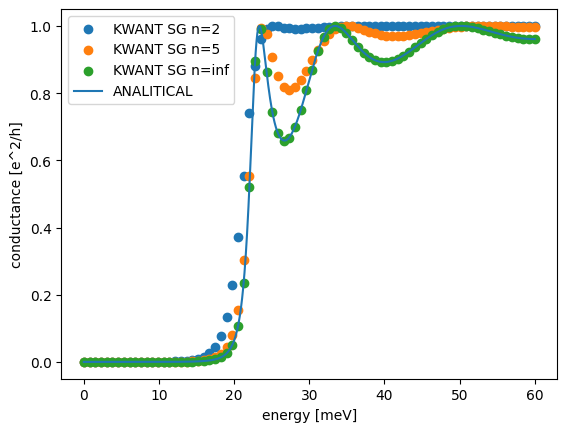

In [96]:

data = []

n = 80
Emax = 3 * v0
energy=np.linspace(0.01,Emax,n)

res=[]

#for i in [2,5,20,50]:

for i in [2,5,"inf"]:
  res_i=[]
  syst=make_syst(i)
  for ie in energy:
    smatrix = kwant.smatrix(syst, ie)
    res_i.append(smatrix.transmission(1, 0))


  plt.scatter(energy, res_i, label="KWANT SG n="+str(i))
  res.append(res_i)


energy=np.linspace(0.001, Emax, 10000)
t = an_sol(energy)
plt.plot(energy, t, label="ANALITICAL")

plt.xlabel("energy [meV]")
plt.ylabel("conductance [e^2/h]")

plt.legend()
plt.show()

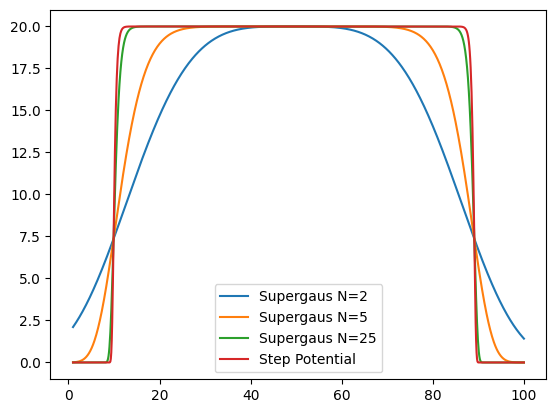

In [97]:
i=np.arange(1,100.1,0.1)
plt.plot(i,v_g(i,N=2),label="Supergaus N=2")
plt.plot(i,v_g(i,N=5),label="Supergaus N=5")
plt.plot(i,v_g(i,N=25),label="Supergaus N=25")
plt.plot(i,v_g(i),label="Step Potential")

plt.legend()
